In [15]:
import os
os.environ["METIS_DLL"] = "/home/budvin/research/Partitioning/metis-5.1.0/build/Linux-x86_64/libmetis/libmetis.so"


In [16]:
import sys
import glob

import gmsh
import networkx as nx
import metis

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget


gmsh.initialize() #sys.argv)

Info    : Reading '../../Meshes/10k_tet/1582380_sf_hexa.mesh_2368_8512.obj.mesh'...
Info    : 8490 nodes
Info    : 0 triangles
Info    : 40363 tetrahedra
Info    : Done reading '../../Meshes/10k_tet/1582380_sf_hexa.mesh_2368_8512.obj.mesh'
1: Model 1582380_sf_hexa.mesh_2368_8512.obj (3D)
  Have  40363  elements and  484356  faces.
[1 2 3 4 5 6 7]
484356
-4.5


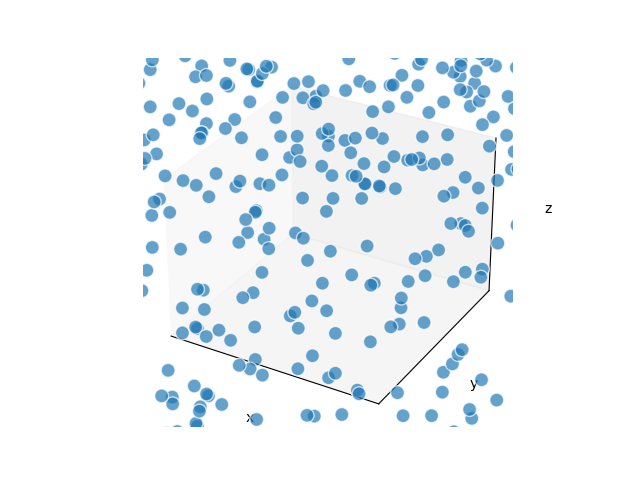

1


In [17]:

results = pd.DataFrame(columns=['num_elems', 'num_faces', 'type', 'npes', 'metis_lambda', 'metis_rho', 'metis_loads', 'metis_comms'])
index = set()
num_files = 0
n_p = 13
folder = r'Meshes/10k_tet/*.mesh'
stop_after = 200



for fname in ['../../Meshes/10k_tet/1582380_sf_hexa.mesh_2368_8512.obj.mesh']:
    gmsh.open(fname)

    if len(results) > 0 and gmsh.model.getCurrent() in index:
        gmsh.clear()
        continue
    
    if num_files > stop_after:
        break
    num_files += 1

    print(str(num_files) + ': Model ' + gmsh.model.getCurrent() + ' (' + str(gmsh.model.getDimension()) + 'D)')
    
    G = nx.Graph()

    entities = gmsh.model.getEntities()
    mesh_type = ''

    for e in entities:
        dim = e[0]
        tag = e[1]

    if dim != 3:
        continue
    
    type = gmsh.model.getType(e[0], e[1])
    name = gmsh.model.getEntityName(e[0], e[1])
    if len(name): name += ' '
    elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)

    if elemTypes[0] == 4:
        mesh_type = 'tet'
        fn = 3
        en = 12 
        elems, _ = gmsh.model.mesh.getElementsByType(4)
        faces    = gmsh.model.mesh.getElementFaceNodes(4, 3)
        _, nodeCoords, _ = gmsh.model.mesh.getNodesByElementType(4)
    else:
        mesh_type = 'hex'
        fn = 4
        en = 24
        elems, _ = gmsh.model.mesh.getElementsByType(5)
        faces    = gmsh.model.mesh.getElementFaceNodes(5, 4)
        _, nodeCoords, _ = gmsh.model.mesh.getNodesByElementType(5)

    print('  Have ', len(elems), ' elements and ', len(faces), ' faces.')

    f2e = {}
    e2e = {}

    V = {}
    for i,x in enumerate(elems):
        v = G.add_node(x)
        V[i] = x

    for i in range(0, len(faces), fn):
        f = tuple(sorted(faces[i:i+fn]))
        t = elems[i//en]
        if not f in f2e:
            f2e[f] = [t]
        else:
            f2e[f].append(t)

    # compute neighbors by face
    for i in range(0, len(faces), fn):
        f = tuple(sorted(faces[i:i+fn]))
        t = elems[i//en]
        if not t in e2e:
            e2e[t] = set()
        for tt in f2e[f]:
            if tt != t:
                e2e[t].add(tt)

    for k in e2e:
        for j in e2e[k]:
            G.add_edge(k,j)
    print(elems[:7])
    elemCenterCoordsXYZ = [[-1,-1,-1] for _ in range(len(elems))]
    for i in range(0,len(nodeCoords),en):
        elem_id = i//en
        x_tot = 0
        y_tot = 0
        z_tot = 0
        for j in range(en):
            if j%3 ==0:
                x_tot+=nodeCoords[i+j]
            if j%3 ==1:
                y_tot+=nodeCoords[i+j]
            if j%3 ==2:
                z_tot+=nodeCoords[i+j]
        elemCenterCoordsXYZ[elem_id][0] = x_tot/4 
        elemCenterCoordsXYZ[elem_id][1] = y_tot/4 
        elemCenterCoordsXYZ[elem_id][2] = z_tot/4          


        pass
    print(len(nodeCoords))
    print(nodeCoords[1])

    # Create the 3D figure
    fig = plt.figure()
    # ax = Axes3D(fig)
    ax = fig.add_subplot(projection="3d")
    plt.axis('equal')
    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*(np.array(elemCenterCoordsXYZ)).T, s=100, ec="w")

    # Plot the edges
    # for vizedge in edge_xyz:
    #     ax.plot(*vizedge.T, color="tab:gray")


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    # fig.tight_layout()
    plt.show()


    # plt.show()
    print(V[0])